In [10]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
filename = "dataset.h5"

with h5py.File(filename, "r") as f:
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    print(type(f[a_group_key]))
    training_x = np.array(f['trX'])
    training_y = np.array(f['trY'])
    test_x = np.array(f['tstX'])
    test_y = np.array(f['tstY'])

Keys: <KeysViewHDF5 ['trX', 'trY', 'tstX', 'tstY']>
<class 'h5py._hl.dataset.Dataset'>


In [13]:
class RecurrentNeuralNetwork_1:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        # Hyperparameters
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.output_size = output_size
        # Initialize weights
        self.W_IH = np.random.uniform(-0.1, 0.1, (hidden_size, input_size + 1))
        self.W_HH = np.random.uniform(-0.1, 0.1, (hidden_size, hidden_size))
        self.W_HO = np.random.uniform(-0.1, 0.1, (output_size, hidden_size + 1))

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def sigmoid_derivative(x):
        return x * (1 - x)

    @staticmethod
    def tanh_derivative(x):
        return 1 - x**2

    @staticmethod
    def cross_entropy(predictions, targets, epsilon=1e-12):
        predictions = np.clip(predictions, epsilon, 1. - epsilon)
        N = predictions.shape[0]
        ce = -np.sum(targets*np.log(predictions+epsilon))/N
        return ce

    def forward_pass(self, inputs):
        T = inputs.shape[0]  # Sequence length
        self.H = np.zeros((T + 1, self.hidden_size))  # Hidden state initialization with one additional for the initial states bias term
        Y = np.zeros((T, self.output_size))  # Output initialization

        for t in range(T):
            x = np.hstack([inputs[t], [1]])  # Add bias term
            self.H[t] = self.tanh(np.dot(self.W_IH, x) + np.dot(self.W_HH, self.H[t-1]))
            y = self.sigmoid(np.dot(self.W_HO, np.hstack([self.H[t], [1]])))
            Y[t] = y

        return Y

    def train(self, train_x, train_y, epochs, batch_size):
        num_samples, sequence_length, num_features = train_x.shape
        _, num_classes = train_y.shape

        epoch_accuracies = []  # To collect training accuracies at the end of each epoch
        filename = f"training_progress_lr{learning_rate}_bs{batch_size}_hs{hidden_size}.txt"
        with open(filename, "w") as file:
          file.write(f"Learning Rate: {learning_rate}, Batch Size: {batch_size}, Hidden Size: {hidden_size}\n")
          for epoch in range(epochs):
              epoch_loss = 0
              correct_train_predictions = 0

              indices = np.arange(num_samples)
              np.random.shuffle(indices)
              shuffled_train_x = train_x[indices]
              shuffled_train_y = train_y[indices]

              for i in range(0, num_samples, batch_size):
                  batch_end = min(i + batch_size, num_samples)
                  batch_inputs = shuffled_train_x[i:batch_end]
                  batch_targets = shuffled_train_y[i:batch_end]

                  # Reset gradients and hidden states
                  dW_IH, dW_HH, dW_HO = np.zeros_like(self.W_IH), np.zeros_like(self.W_HH), np.zeros_like(self.W_HO)
                  db_H, db_O = np.zeros((self.hidden_size, 1)), np.zeros((self.output_size, 1))
                  h_prev = np.zeros((self.hidden_size, 1))

                  batch_loss = 0

                  for t in range(sequence_length):
                      x = np.hstack([batch_inputs[:, t, :], np.ones((batch_end - i, 1))])  # Add bias term
                      y_true = batch_targets

                      # Forward pass
                      h_prev = np.tanh(np.dot(self.W_IH, x.T) + np.dot(self.W_HH, h_prev))
                      y_pred = self.sigmoid(np.dot(self.W_HO, np.vstack([h_prev, np.ones((1, batch_end - i))])))

                      if t == sequence_length - 1:  # Compute loss
                          batch_loss += np.sum(self.cross_entropy(y_pred.T, y_true))
                          correct_train_predictions += np.sum(np.argmax(y_pred, axis=0) == np.argmax(y_true, axis=1))

                      # Bptt
                      delta_o = (y_pred - y_true.T) * self.sigmoid_derivative(y_pred)
                      dW_HO += np.dot(delta_o, np.vstack([h_prev, np.ones((1, batch_end - i))]).T)
                      delta_h = np.dot(self.W_HO.T, delta_o)[:-1] * self.tanh_derivative(h_prev)

                      dW_HH += np.dot(delta_h, h_prev.T)
                      dW_IH += np.dot(delta_h, x)

                  # Update weights after the batch
                  self.W_IH -= self.learning_rate * dW_IH / sequence_length
                  self.W_HH -= self.learning_rate * dW_HH / sequence_length
                  self.W_HO -= self.learning_rate * dW_HO / sequence_length

                  epoch_loss += batch_loss / (batch_end - i)

              # Average loss and accuracy for the epoch
              epoch_loss /= (num_samples / batch_size)
              train_accuracy = correct_train_predictions / num_samples
              epoch_accuracies.append(train_accuracy)

              file.write(f"Epoch {epoch + 1}, Average Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%\n")
              print((f"Epoch {epoch + 1}, Average Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%\n"))

          return epoch_accuracies

    def evaluate(self, test_x, test_y, learning_rate, batch_size, hidden_layer_size):
      total_loss = 0
      correct_predictions = 0
      class_correct = dict()
      class_total = dict()

      # filename for each combination of parameters
      filename = f"misclassified_patterns_lr{learning_rate}_bs{batch_size}_hl{hidden_layer_size}.txt"

      with open(filename, "w") as file:
          for i in range(len(test_x)):
              outputs = self.forward_pass(test_x[i])
              total_loss += self.cross_entropy(outputs[-1], test_y[i])
              predicted = np.argmax(outputs[-1])
              actual = np.argmax(test_y[i])

              correct_predictions += int(predicted == actual)

              if actual in class_correct:
                  class_correct[actual] += int(predicted == actual)
              else:
                  class_correct[actual] = int(predicted == actual)

              if actual in class_total:
                  class_total[actual] += 1
              else:
                  class_total[actual] = 1

              # misclassified patterns
              if predicted != actual:
                  file.write(f"Index: {i}, Actual: {actual}, Predicted: {predicted}, Input: {test_x[i]}\n")

      average_loss = total_loss / len(test_x)
      accuracy = correct_predictions / len(test_x) * 100
      per_class_accuracy = {cls: class_correct[cls] / class_total[cls] * 100 for cls in class_correct}

      return average_loss, accuracy, per_class_accuracy

def plot_training_accuracy(epoch_accuracies):
    epochs = range(1, len(epoch_accuracies) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, epoch_accuracies, marker='o', linestyle='-')
    plt.title('Training Accuracy vs. Number of Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Training Accuracy')
    plt.grid(True)
    plt.show()

def plot_per_class_accuracy(per_class_accuracy):
    classes = list(per_class_accuracy.keys())
    accuracies = list(per_class_accuracy.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, accuracies, align='center', alpha=0.7)
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-Class Accuracy')
    plt.xticks(classes)
    plt.grid(axis='y')
    plt.show()


Training Progress is recorded in the files:
training_progress_lr{learning_rate}_bs{batch_size}_hs{hidden_size}.txt

Learning Rate: 0.05   Hidden Size: 50   Batch Size: 10
Epoch 1, Average Loss: 0.1508, Training Accuracy: 33.13%

Epoch 2, Average Loss: 0.1459, Training Accuracy: 40.27%

Epoch 3, Average Loss: 0.1412, Training Accuracy: 43.50%

Epoch 4, Average Loss: 0.1374, Training Accuracy: 46.43%

Epoch 5, Average Loss: 0.1349, Training Accuracy: 47.17%

Epoch 6, Average Loss: 0.1308, Training Accuracy: 48.37%

Epoch 7, Average Loss: 0.1244, Training Accuracy: 50.23%

Epoch 8, Average Loss: 0.1187, Training Accuracy: 52.70%

Epoch 9, Average Loss: 0.1173, Training Accuracy: 53.70%

Epoch 10, Average Loss: 0.1104, Training Accuracy: 56.20%

Epoch 11, Average Loss: 0.1083, Training Accuracy: 57.70%

Epoch 12, Average Loss: 0.1041, Training Accuracy: 59.33%

Epoch 13, Average Loss: 0.1034, Training Accuracy: 59.60%

Epoch 14, Average Loss: 0.1015, Training Accuracy: 61.20%

Epoch 15, Average Loss: 0.0972, Training Accuracy: 62.43%

Epoch 16, Average Loss: 0.0945, Training Accuracy: 62.80%

Epoch 17, 

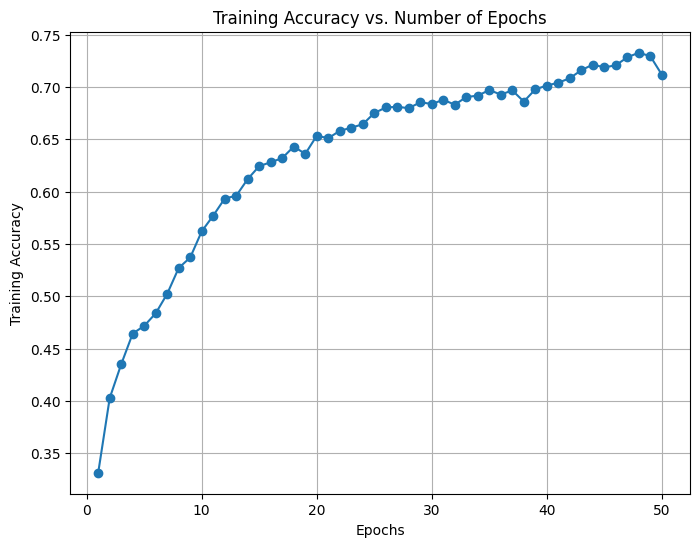

The Accuracy is: 69.33333333333334


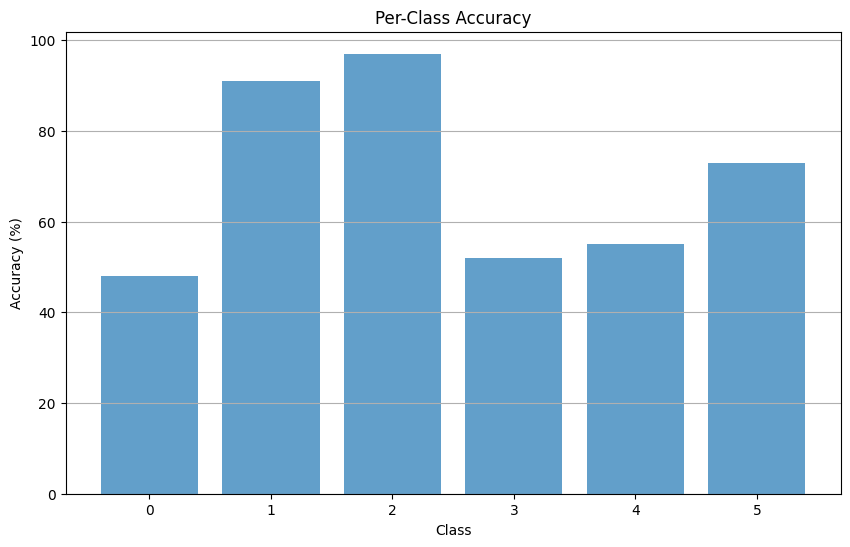

------------------------------------------------------------
Learning Rate: 0.05   Hidden Size: 50   Batch Size: 30
Epoch 1, Average Loss: 0.0507, Training Accuracy: 30.67%

Epoch 2, Average Loss: 0.0492, Training Accuracy: 39.60%

Epoch 3, Average Loss: 0.0488, Training Accuracy: 41.53%

Epoch 4, Average Loss: 0.0473, Training Accuracy: 44.47%

Epoch 5, Average Loss: 0.0461, Training Accuracy: 46.07%

Epoch 6, Average Loss: 0.0448, Training Accuracy: 47.73%

Epoch 7, Average Loss: 0.0430, Training Accuracy: 49.40%

Epoch 8, Average Loss: 0.0428, Training Accuracy: 50.63%

Epoch 9, Average Loss: 0.0414, Training Accuracy: 51.70%

Epoch 10, Average Loss: 0.0403, Training Accuracy: 52.40%

Epoch 11, Average Loss: 0.0389, Training Accuracy: 53.43%

Epoch 12, Average Loss: 0.0399, Training Accuracy: 53.00%

Epoch 13, Average Loss: 0.0384, Training Accuracy: 53.77%

Epoch 14, Average Loss: 0.0388, Training Accuracy: 54.63%

Epoch 15, Average Loss: 0.0363, Training Accuracy: 57.43%

Epoch 16

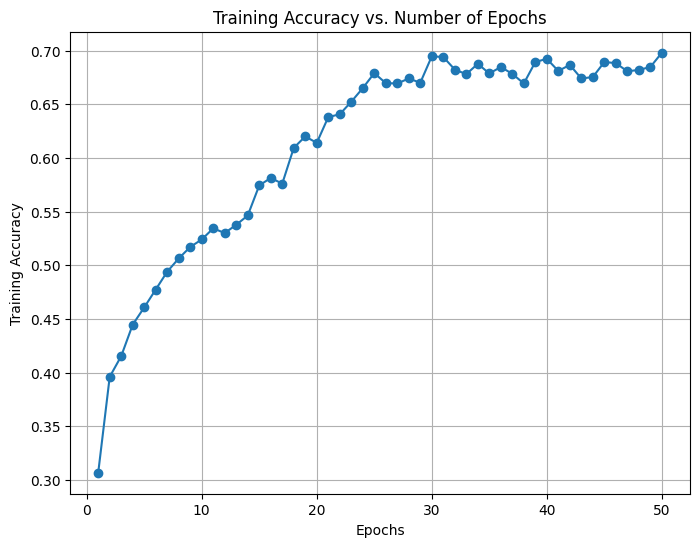

The Accuracy is: 58.166666666666664


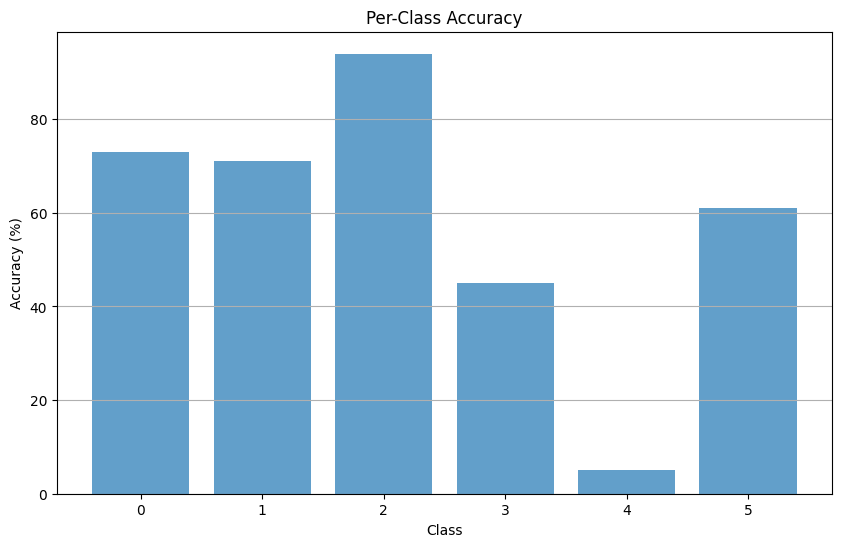

------------------------------------------------------------
Learning Rate: 0.05   Hidden Size: 100   Batch Size: 10
Epoch 1, Average Loss: 0.1501, Training Accuracy: 33.83%

Epoch 2, Average Loss: 0.1470, Training Accuracy: 40.87%

Epoch 3, Average Loss: 0.1430, Training Accuracy: 41.33%

Epoch 4, Average Loss: 0.1390, Training Accuracy: 43.67%

Epoch 5, Average Loss: 0.1354, Training Accuracy: 44.97%

Epoch 6, Average Loss: 0.1334, Training Accuracy: 45.77%

Epoch 7, Average Loss: 0.1311, Training Accuracy: 47.93%

Epoch 8, Average Loss: 0.1238, Training Accuracy: 49.50%

Epoch 9, Average Loss: 0.1201, Training Accuracy: 52.47%

Epoch 10, Average Loss: 0.1168, Training Accuracy: 53.20%

Epoch 11, Average Loss: 0.1145, Training Accuracy: 53.10%

Epoch 12, Average Loss: 0.1123, Training Accuracy: 56.00%

Epoch 13, Average Loss: 0.1052, Training Accuracy: 57.87%

Epoch 14, Average Loss: 0.0987, Training Accuracy: 60.97%

Epoch 15, Average Loss: 0.0987, Training Accuracy: 61.67%

Epoch 1

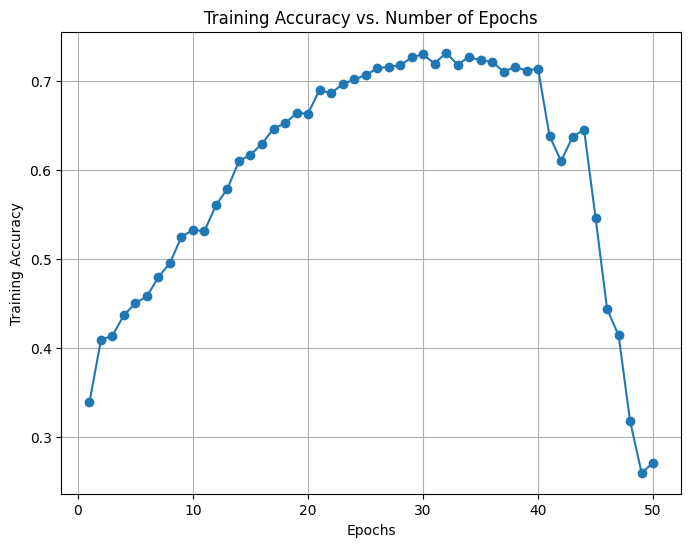

The Accuracy is: 26.0


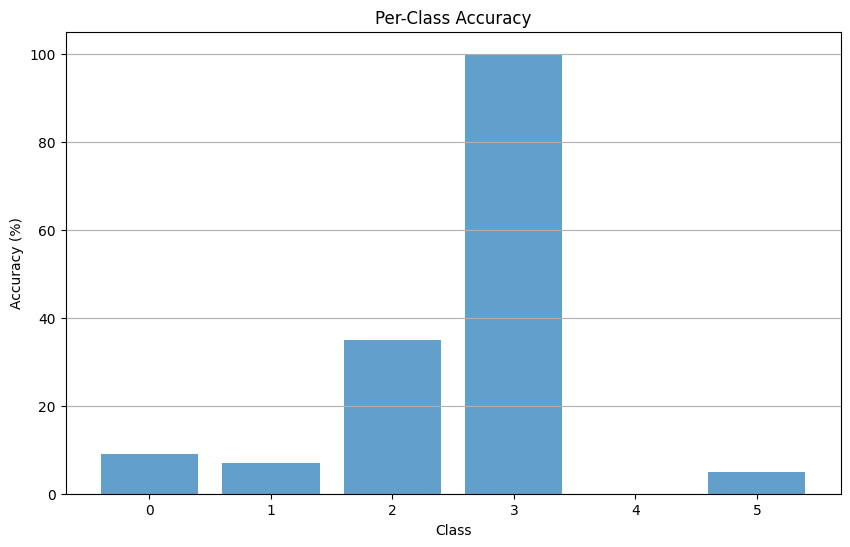

------------------------------------------------------------
Learning Rate: 0.05   Hidden Size: 100   Batch Size: 30
Epoch 1, Average Loss: 0.0508, Training Accuracy: 33.80%

Epoch 2, Average Loss: 0.0501, Training Accuracy: 38.47%

Epoch 3, Average Loss: 0.0491, Training Accuracy: 42.00%

Epoch 4, Average Loss: 0.0484, Training Accuracy: 40.87%

Epoch 5, Average Loss: 0.0468, Training Accuracy: 42.63%

Epoch 6, Average Loss: 0.0455, Training Accuracy: 45.53%

Epoch 7, Average Loss: 0.0442, Training Accuracy: 47.93%

Epoch 8, Average Loss: 0.0422, Training Accuracy: 49.73%

Epoch 9, Average Loss: 0.0413, Training Accuracy: 51.47%

Epoch 10, Average Loss: 0.0399, Training Accuracy: 53.43%

Epoch 11, Average Loss: 0.0403, Training Accuracy: 53.77%

Epoch 12, Average Loss: 0.0372, Training Accuracy: 56.33%

Epoch 13, Average Loss: 0.0355, Training Accuracy: 59.57%

Epoch 14, Average Loss: 0.0331, Training Accuracy: 60.87%

Epoch 15, Average Loss: 0.0312, Training Accuracy: 62.90%

Epoch 1

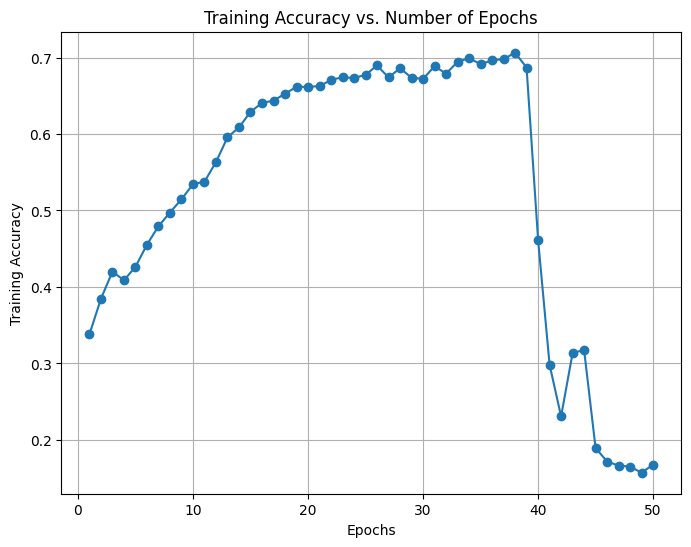

The Accuracy is: 16.666666666666664


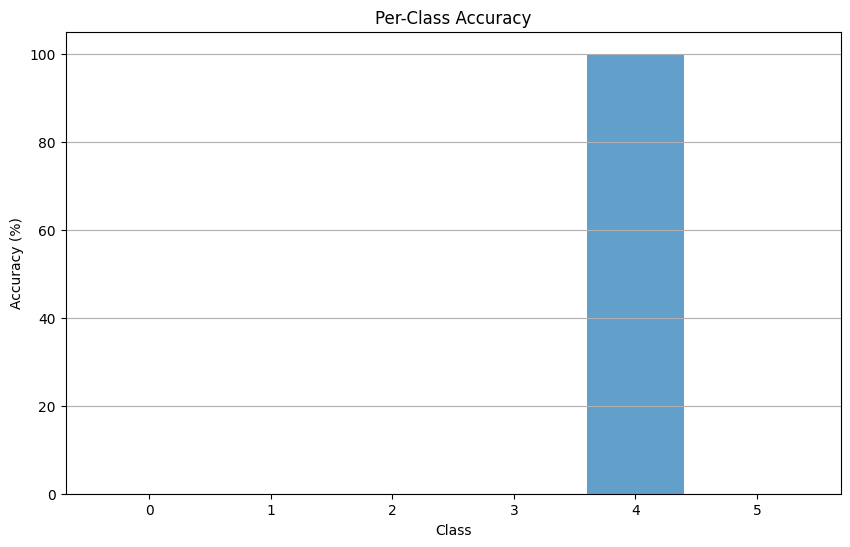

------------------------------------------------------------
Learning Rate: 0.1   Hidden Size: 50   Batch Size: 10
Epoch 1, Average Loss: 0.1539, Training Accuracy: 34.33%

Epoch 2, Average Loss: 0.1483, Training Accuracy: 42.00%

Epoch 3, Average Loss: 0.1438, Training Accuracy: 44.23%

Epoch 4, Average Loss: 0.1379, Training Accuracy: 46.73%

Epoch 5, Average Loss: 0.1333, Training Accuracy: 48.20%

Epoch 6, Average Loss: 0.1249, Training Accuracy: 51.37%

Epoch 7, Average Loss: 0.1200, Training Accuracy: 54.50%

Epoch 8, Average Loss: 0.1157, Training Accuracy: 56.53%

Epoch 9, Average Loss: 0.1055, Training Accuracy: 60.00%

Epoch 10, Average Loss: 0.1050, Training Accuracy: 61.40%

Epoch 11, Average Loss: 0.1073, Training Accuracy: 60.13%

Epoch 12, Average Loss: 0.1054, Training Accuracy: 61.53%

Epoch 13, Average Loss: 0.1094, Training Accuracy: 58.53%

Epoch 14, Average Loss: 0.1202, Training Accuracy: 56.30%

Epoch 15, Average Loss: 0.1196, Training Accuracy: 56.53%

Epoch 16,

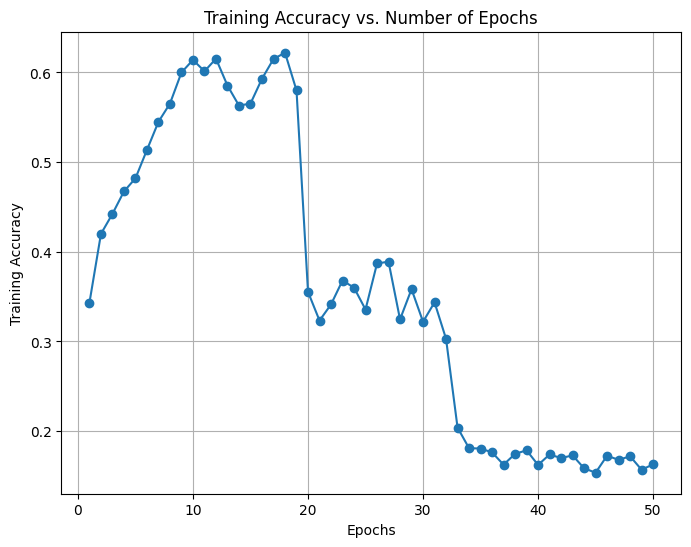

The Accuracy is: 16.5


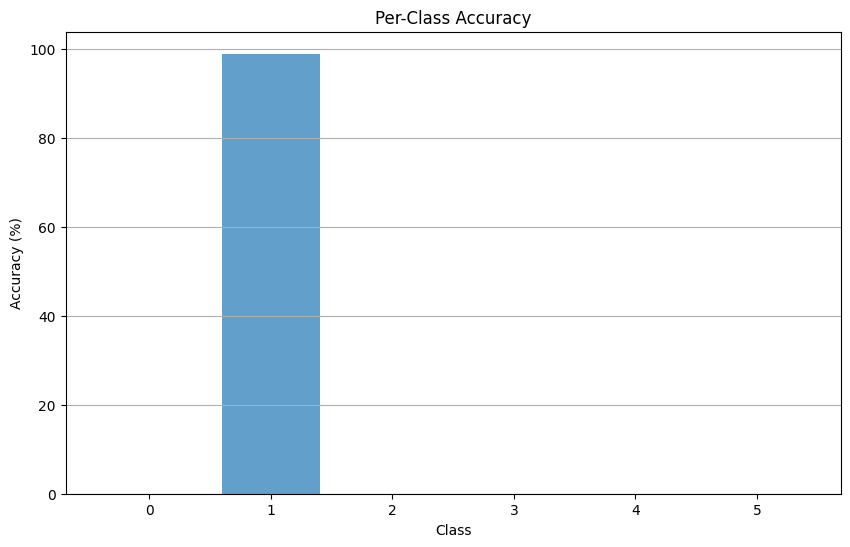

------------------------------------------------------------
Learning Rate: 0.1   Hidden Size: 50   Batch Size: 30
Epoch 1, Average Loss: 0.0511, Training Accuracy: 35.00%

Epoch 2, Average Loss: 0.0502, Training Accuracy: 41.10%

Epoch 3, Average Loss: 0.0488, Training Accuracy: 43.17%

Epoch 4, Average Loss: 0.0467, Training Accuracy: 45.73%

Epoch 5, Average Loss: 0.0436, Training Accuracy: 49.13%

Epoch 6, Average Loss: 0.0410, Training Accuracy: 52.87%

Epoch 7, Average Loss: 0.0394, Training Accuracy: 56.43%

Epoch 8, Average Loss: 0.0369, Training Accuracy: 57.83%

Epoch 9, Average Loss: 0.0361, Training Accuracy: 59.47%

Epoch 10, Average Loss: 0.0353, Training Accuracy: 60.40%

Epoch 11, Average Loss: 0.0568, Training Accuracy: 36.53%

Epoch 12, Average Loss: 0.0756, Training Accuracy: 17.07%

Epoch 13, Average Loss: 0.0762, Training Accuracy: 15.93%

Epoch 14, Average Loss: 0.0793, Training Accuracy: 15.23%

Epoch 15, Average Loss: 0.0723, Training Accuracy: 15.43%

Epoch 16,

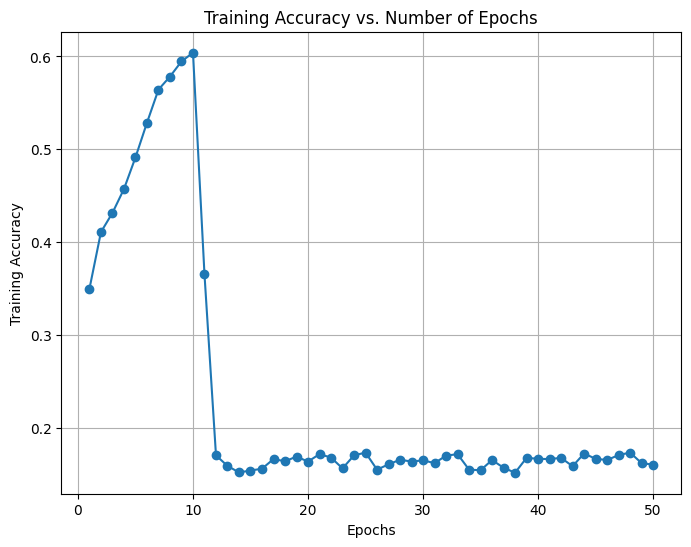

The Accuracy is: 16.666666666666664


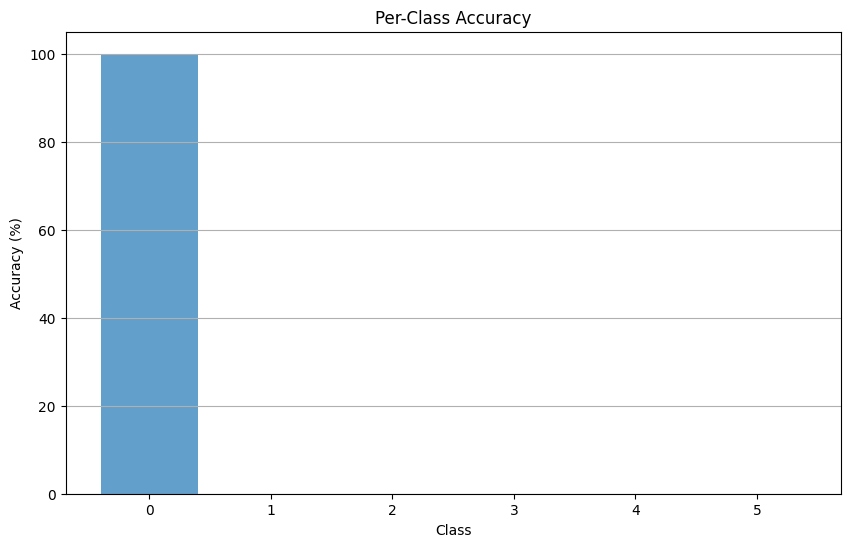

------------------------------------------------------------
Learning Rate: 0.1   Hidden Size: 100   Batch Size: 10
Epoch 1, Average Loss: 0.1543, Training Accuracy: 36.20%

Epoch 2, Average Loss: 0.1496, Training Accuracy: 40.70%

Epoch 3, Average Loss: 0.1396, Training Accuracy: 45.90%

Epoch 4, Average Loss: 0.1285, Training Accuracy: 49.50%

Epoch 5, Average Loss: 0.1233, Training Accuracy: 52.47%

Epoch 6, Average Loss: 0.1204, Training Accuracy: 53.27%

Epoch 7, Average Loss: 0.1104, Training Accuracy: 57.13%

Epoch 8, Average Loss: 0.1051, Training Accuracy: 59.40%

Epoch 9, Average Loss: 0.1352, Training Accuracy: 44.87%

Epoch 10, Average Loss: 0.1874, Training Accuracy: 17.97%

Epoch 11, Average Loss: 0.1869, Training Accuracy: 17.17%

Epoch 12, Average Loss: 0.1874, Training Accuracy: 16.37%

Epoch 13, Average Loss: 0.1864, Training Accuracy: 18.40%

Epoch 14, Average Loss: 0.1861, Training Accuracy: 16.67%

Epoch 15, Average Loss: 0.1901, Training Accuracy: 16.17%

Epoch 16

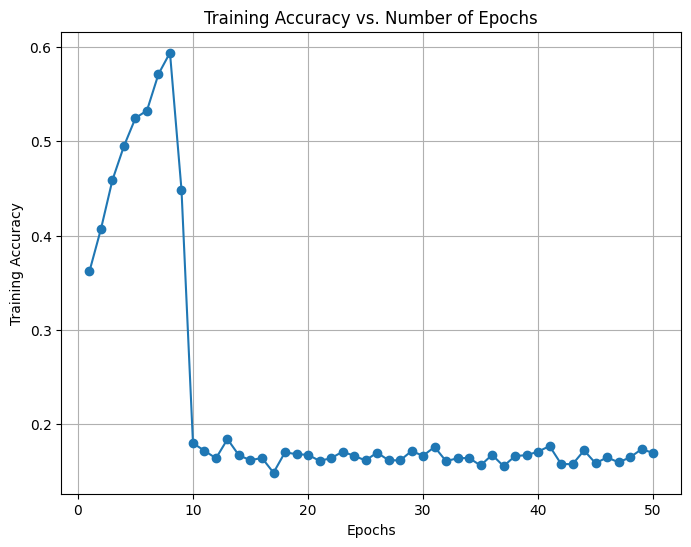

The Accuracy is: 14.000000000000002


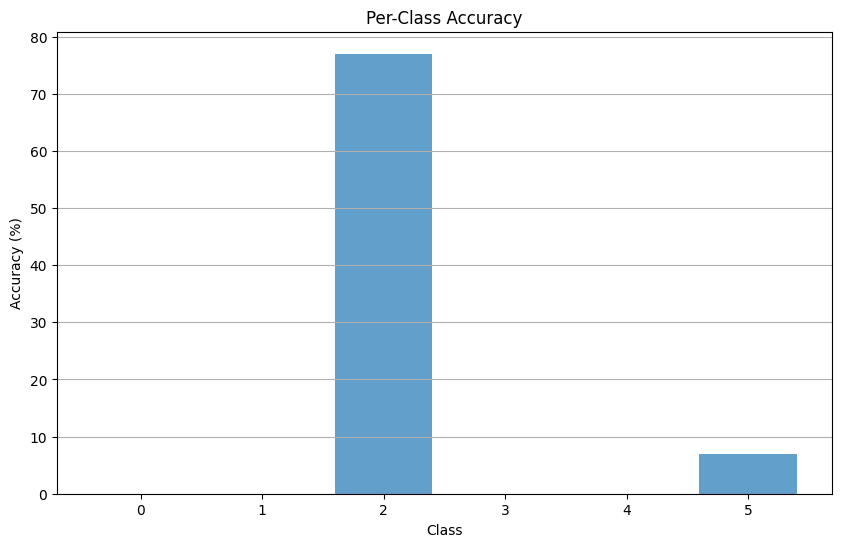

------------------------------------------------------------
Learning Rate: 0.1   Hidden Size: 100   Batch Size: 30
Epoch 1, Average Loss: 0.0521, Training Accuracy: 35.10%

Epoch 2, Average Loss: 0.0507, Training Accuracy: 39.23%

Epoch 3, Average Loss: 0.0486, Training Accuracy: 43.57%

Epoch 4, Average Loss: 0.0481, Training Accuracy: 45.00%

Epoch 5, Average Loss: 0.0447, Training Accuracy: 48.90%

Epoch 6, Average Loss: 0.2306, Training Accuracy: 16.50%

Epoch 7, Average Loss: 0.2879, Training Accuracy: 17.13%

Epoch 8, Average Loss: 0.3219, Training Accuracy: 16.67%

Epoch 9, Average Loss: 0.3030, Training Accuracy: 16.57%

Epoch 10, Average Loss: 0.3164, Training Accuracy: 17.50%

Epoch 11, Average Loss: 0.2867, Training Accuracy: 16.67%

Epoch 12, Average Loss: 0.2665, Training Accuracy: 16.67%

Epoch 13, Average Loss: 0.2410, Training Accuracy: 16.67%

Epoch 14, Average Loss: 0.2380, Training Accuracy: 16.67%

Epoch 15, Average Loss: 0.3225, Training Accuracy: 16.67%

Epoch 16

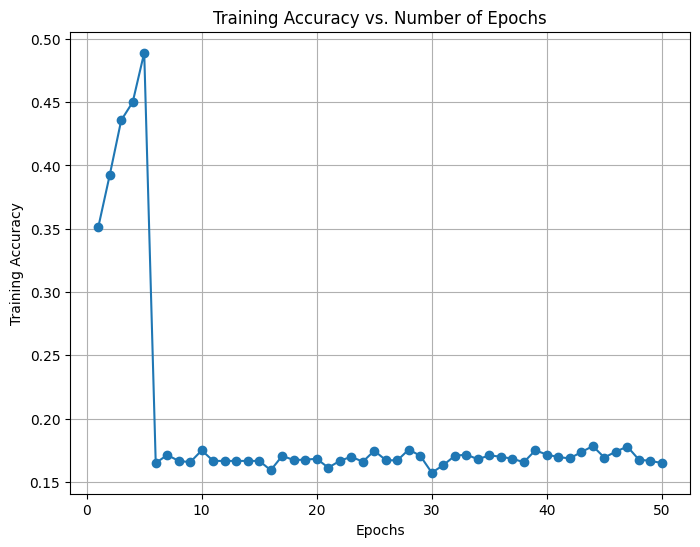

The Accuracy is: 16.666666666666664


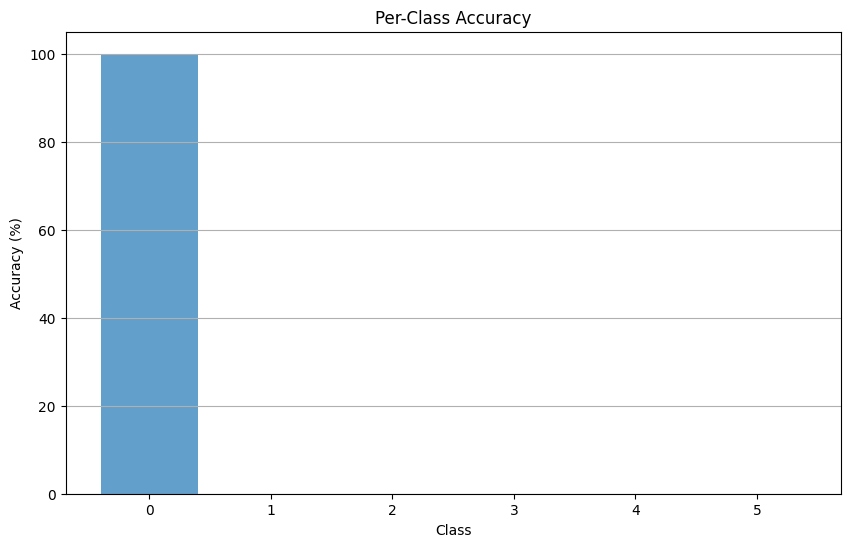

------------------------------------------------------------


In [14]:
input_size = 3
output_size = 6

learning_rates = [0.05, 0.1]
hidden_sizes = [50, 100]
batch_sizes = [10, 30]
epochs = 50

for learning_rate in learning_rates:
    for hidden_size in hidden_sizes:
        for batch_size in batch_sizes:
            print('Learning Rate:', learning_rate , ' ' , 'Hidden Size:', hidden_size , ' ' ,'Batch Size:', batch_size)
            rnn = RecurrentNeuralNetwork_1(input_size, hidden_size, output_size, learning_rate)
            epoch_accuracies = rnn.train(training_x, training_y, epochs, batch_size)
            plot_training_accuracy(epoch_accuracies)
            _, accuracy, per_class_accuracy = rnn.evaluate(test_x, test_y,learning_rate, batch_size, hidden_size)
            print(f'The Accuracy is: {accuracy}')
            plot_per_class_accuracy(per_class_accuracy)
            print('------------------------------------------------------------')

In [25]:
class RecurrentNeuralNetwork_2:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        # parameters
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.output_size = output_size
        # Initialize weights
        self.W_IH = np.random.uniform(-0.1, 0.1, (hidden_size, input_size + 1))
        self.W_HH = np.random.uniform(-0.1, 0.1, (hidden_size, hidden_size))
        self.W_HO = np.random.uniform(-0.1, 0.1, (output_size, hidden_size + 1))

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def sigmoid_derivative(x):
        return x * (1 - x)

    @staticmethod
    def tanh_derivative(x):
        return 1 - x**2

    @staticmethod
    def cross_entropy(predictions, targets, epsilon=1e-12):
        predictions = np.clip(predictions, epsilon, 1. - epsilon)
        N = predictions.shape[0]
        ce = -np.sum(targets*np.log(predictions+epsilon))/N
        return ce

    def forward_pass(self, inputs): # Just used for evaluate, it already implemented in train method
      T, _ = inputs.shape
      self.H = np.zeros((T + 1, self.hidden_size))
      Y = np.zeros((T, self.output_size))

      for t in range(T):
          x = inputs[t]
          if x.ndim == 1:
              x = np.hstack([x, [1]])
          else:
              x = np.hstack([x, np.ones((x.shape[0], 1))])  # Add bias to each sample in the batch
          self.H[t] = self.tanh(np.dot(self.W_IH, x) + np.dot(self.W_HH, self.H[t-1]))
          y = self.sigmoid(np.dot(self.W_HO, np.hstack([self.H[t], [1]])))
          Y[t] = y

      return Y

    def train(self, train_x, train_y, epochs, batch_size, early_stopping=True, patience=6): # Patience value is for early stopping
      num_samples, sequence_length, num_features = train_x.shape
      _, num_classes = train_y.shape

      # Define 10% of training set as validation set
      val_size = int(0.1 * num_samples)
      val_indices = np.random.choice(num_samples, val_size, replace=False)
      train_indices = np.array([i for i in range(num_samples) if i not in val_indices])

      # Separating the validation set from the training set
      validation_x = train_x[val_indices]
      validation_y = train_y[val_indices]
      train_x = train_x[train_indices]
      train_y = train_y[train_indices]

      best_val_loss = float('inf')
      val_loss_increase_count = 0
      validation_losses = []

      for epoch in range(epochs):
          epoch_loss = 0
          correct_train_predictions = 0

          indices = np.arange(train_indices.shape[0])
          np.random.shuffle(indices)
          shuffled_train_x = train_x[indices]
          shuffled_train_y = train_y[indices]

          for i in range(0, train_indices.shape[0], batch_size):
              batch_end = min(i + batch_size, train_indices.shape[0])
              batch_inputs = shuffled_train_x[i:batch_end]
              batch_targets = shuffled_train_y[i:batch_end]

              # Reset gradients and hidden states
              dW_IH, dW_HH, dW_HO = np.zeros_like(self.W_IH), np.zeros_like(self.W_HH), np.zeros_like(self.W_HO)
              h_prev = np.zeros((self.hidden_size, 1))

              batch_loss = 0

              for t in range(sequence_length):
                  x = np.hstack([batch_inputs[:, t, :], np.ones((batch_end - i, 1))])  # Add bias term
                  y_true = batch_targets

                  # Forward pass
                  h_prev = np.tanh(np.dot(self.W_IH, x.T) + np.dot(self.W_HH, h_prev))
                  y_pred = self.sigmoid(np.dot(self.W_HO, np.vstack([h_prev, np.ones((1, batch_end - i))])))

                  if t == sequence_length - 1:  # Compute loss
                      batch_loss += np.sum(self.cross_entropy(y_pred.T, y_true))
                      correct_train_predictions += np.sum(np.argmax(y_pred, axis=0) == np.argmax(y_true, axis=1))

                  # BPTT
                  delta_o = (y_pred - y_true.T) * self.sigmoid_derivative(y_pred)
                  dW_HO += np.dot(delta_o, np.vstack([h_prev, np.ones((1, batch_end - i))]).T)
                  delta_h = np.dot(self.W_HO.T, delta_o)[:-1] * self.tanh_derivative(h_prev)

                  dW_HH += np.dot(delta_h, h_prev.T)
                  dW_IH += np.dot(delta_h, x)

              # Update weights after the batch
              self.W_IH -= self.learning_rate * dW_IH / sequence_length
              self.W_HH -= self.learning_rate * dW_HH / sequence_length
              self.W_HO -= self.learning_rate * dW_HO / sequence_length

              epoch_loss += batch_loss / (batch_end - i)

          # Average loss and accuracy
          epoch_loss /= (train_indices.shape[0] / batch_size)
          train_accuracy = correct_train_predictions / train_indices.shape[0]

          # Validation
          val_loss = 0
          correct_val_predictions = 0
          for i in range(0, val_size, batch_size):
              batch_end = min(i + batch_size, val_size)
              batch_inputs = validation_x[i:batch_end]
              batch_targets = validation_y[i:batch_end]

              # Perform forward pass for validation set
              h_prev = np.zeros((self.hidden_size, 1))
              for t in range(sequence_length):
                  x = np.hstack([batch_inputs[:, t, :], np.ones((batch_end - i, 1))])  # Add bias term
                  h_prev = np.tanh(np.dot(self.W_IH, x.T) + np.dot(self.W_HH, h_prev))
                  y_pred = self.sigmoid(np.dot(self.W_HO, np.vstack([h_prev, np.ones((1, batch_end - i))])))

                  if t == sequence_length - 1:  # Compute loss
                      val_loss += np.sum(self.cross_entropy(y_pred.T, batch_targets))

              correct_val_predictions += np.sum(np.argmax(y_pred, axis=0) == np.argmax(batch_targets, axis=1))

          val_loss /= val_size
          validation_losses.append(val_loss)
          val_accuracy = correct_val_predictions / val_size

          # Early stopping
          if early_stopping:
              if val_loss < best_val_loss:
                  best_val_loss = val_loss
                  val_loss_increase_count = 0
              else:
                  val_loss_increase_count += 1
                  if val_loss_increase_count >= patience:
                      print(f"Early stopping after epoch {epoch + 1}")
                      break

          # Print epoch stats
          print(f"Epoch {epoch + 1}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

      return best_val_loss, validation_losses

    def evaluate(self, test_x, test_y):
      total_loss = 0
      correct_predictions = 0
      class_correct = dict()
      class_total = dict()

      for i in range(len(test_x)):
          outputs = self.forward_pass(test_x[i])
          total_loss += self.cross_entropy(outputs[-1], test_y[i])
          predicted = np.argmax(outputs[-1])
          actual = np.argmax(test_y[i])

          correct_predictions += int(predicted == actual)

          if actual in class_correct:
              class_correct[actual] += int(predicted == actual)
          else:
              class_correct[actual] = int(predicted == actual)

          if actual in class_total:
              class_total[actual] += 1
          else:
              class_total[actual] = 1

      average_loss = total_loss / len(test_x)
      accuracy = correct_predictions / len(test_x) * 100

      per_class_accuracy = {cls: class_correct[cls] / class_total[cls] * 100 for cls in class_correct}

      return average_loss, accuracy, per_class_accuracy

Learning Rate: 0.05   Hidden Size: 50   Batch Size: 10
Epoch 1, Training Loss: 0.1513, Training Accuracy: 32.85%, Validation Loss: 0.1561, Validation Accuracy: 39.00%
Epoch 2, Training Loss: 0.1473, Training Accuracy: 39.81%, Validation Loss: 0.1424, Validation Accuracy: 40.00%
Epoch 3, Training Loss: 0.1423, Training Accuracy: 43.52%, Validation Loss: 0.1429, Validation Accuracy: 44.67%
Epoch 4, Training Loss: 0.1387, Training Accuracy: 43.93%, Validation Loss: 0.1275, Validation Accuracy: 45.00%
Epoch 5, Training Loss: 0.1327, Training Accuracy: 45.89%, Validation Loss: 0.1254, Validation Accuracy: 50.33%
Epoch 6, Training Loss: 0.1283, Training Accuracy: 48.15%, Validation Loss: 0.1329, Validation Accuracy: 47.33%
Epoch 7, Training Loss: 0.1230, Training Accuracy: 49.59%, Validation Loss: 0.1147, Validation Accuracy: 53.67%
Epoch 8, Training Loss: 0.1187, Training Accuracy: 51.63%, Validation Loss: 0.1126, Validation Accuracy: 54.67%
Epoch 9, Training Loss: 0.1136, Training Accuracy

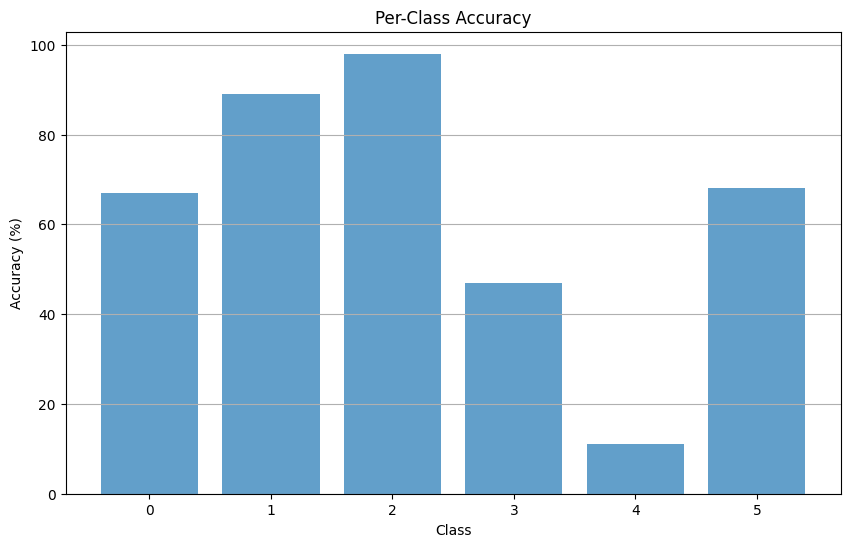

------------------------------------------------------------
Learning Rate: 0.05   Hidden Size: 50   Batch Size: 30
Epoch 1, Training Loss: 0.0505, Training Accuracy: 32.74%, Validation Loss: 0.0555, Validation Accuracy: 31.67%
Epoch 2, Training Loss: 0.0500, Training Accuracy: 39.22%, Validation Loss: 0.0508, Validation Accuracy: 42.67%
Epoch 3, Training Loss: 0.0490, Training Accuracy: 40.78%, Validation Loss: 0.0491, Validation Accuracy: 42.33%
Epoch 4, Training Loss: 0.0477, Training Accuracy: 42.56%, Validation Loss: 0.0516, Validation Accuracy: 43.67%
Epoch 5, Training Loss: 0.0466, Training Accuracy: 44.44%, Validation Loss: 0.0459, Validation Accuracy: 42.67%
Epoch 6, Training Loss: 0.0464, Training Accuracy: 45.78%, Validation Loss: 0.0481, Validation Accuracy: 45.33%
Epoch 7, Training Loss: 0.0452, Training Accuracy: 47.30%, Validation Loss: 0.0452, Validation Accuracy: 45.33%
Epoch 8, Training Loss: 0.0433, Training Accuracy: 48.22%, Validation Loss: 0.0459, Validation Accur

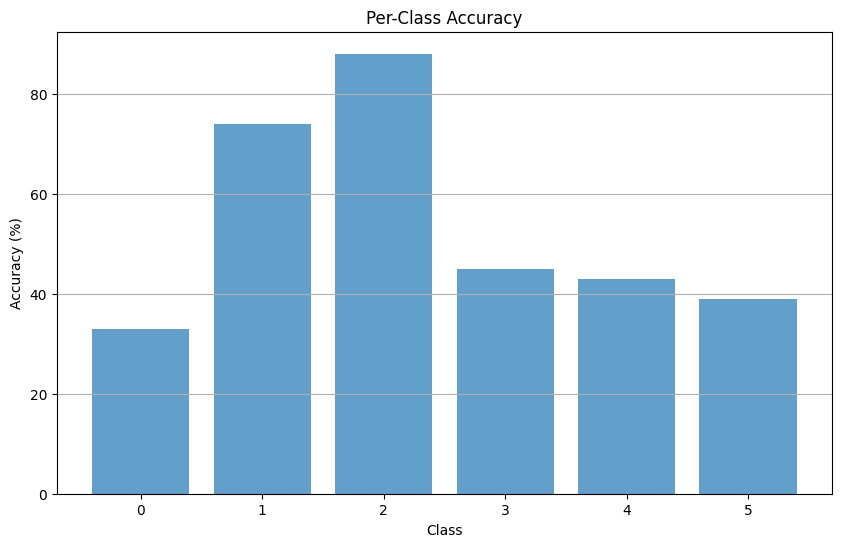

------------------------------------------------------------


In [26]:
# RNN
input_size = 3
output_size = 6

learning_rate = 0.05
hidden_size = 50
batch_sizes = [10,30]
epochs = 50

for batch_size in batch_sizes:
  print('Learning Rate:', learning_rate , ' ' , 'Hidden Size:', hidden_size , ' ' ,'Batch Size:', batch_size)
  rnn_2 = RecurrentNeuralNetwork_2(input_size, hidden_size, output_size, learning_rate)
  rnn_2.train(training_x, training_y, epochs, batch_size)
  _, accuracy, per_class_accuracy = rnn_2.evaluate(test_x, test_y)
  print(f'The Accuracy is: {accuracy}')
  plot_per_class_accuracy(per_class_accuracy)
  print('------------------------------------------------------------')